In [86]:
import glob
import os
import random

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

# Preprocessing

## Stats

In [16]:
def calculate_dataset_stats(dataset_dir):
    sum_r = sum_g = sum_b = 0.0
    sum_sq_r = sum_sq_g = sum_sq_b = 0.0
    total_pixels = 0
    processed_files = 0
    problematic_files = []

    total_images = 0
    for class_dir in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_dir)
        if os.path.isdir(class_path):
            total_images += len([f for f in os.listdir(class_path) 
                               if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    with tqdm(total=total_images, desc="Processing Images", 
             unit="img", dynamic_ncols=True) as pbar:
        
        for class_dir in os.listdir(dataset_dir):
            class_path = os.path.join(dataset_dir, class_dir)
            if not os.path.isdir(class_path):
                continue

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    problematic_files.append(f"{img_path} - Not an image")
                    pbar.update(1)
                    continue
                
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        raise ValueError("OpenCV failed to read image")
                        
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    if img.dtype != np.uint8:
                        raise ValueError(f"Unexpected dtype: {img.dtype}")
                        
                    img = img.astype(np.float32) / 255.0
                    
                    sum_r += np.sum(img[:, :, 0])
                    sum_g += np.sum(img[:, :, 1])
                    sum_b += np.sum(img[:, :, 2])
                    
                    sum_sq_r += np.sum(np.square(img[:, :, 0]))
                    sum_sq_g += np.sum(np.square(img[:, :, 1]))
                    sum_sq_b += np.sum(np.square(img[:, :, 2]))
                    
                    total_pixels += img.shape[0] * img.shape[1]
                    processed_files += 1

                except Exception as e:
                    problematic_files.append(f"{img_path} - {str(e)}")
                
                finally:
                    pbar.update(1)
                    pbar.set_postfix({
                        'Processed': processed_files,
                        'Errors': len(problematic_files),
                        'Current': os.path.basename(class_dir)
                    })

    if total_pixels == 0:
        raise ValueError("No valid images processed - check dataset path or file formats")

    mean = [
        round(sum_r / total_pixels, 5),
        round(sum_g / total_pixels, 5),
        round(sum_b / total_pixels, 5)
    ]
    
    std = [
        round(np.sqrt((sum_sq_r / total_pixels) - (mean[0] ** 2)), 5),
        round(np.sqrt((sum_sq_g / total_pixels) - (mean[1] ** 2)), 5),
        round(np.sqrt((sum_sq_b / total_pixels) - (mean[2] ** 2)), 5)
    ]

    print("\nValidation Summary:")
    print(f"Total images attempted: {total_images}")
    print(f"Successfully processed: {processed_files}")
    print(f"Problematic files: {len(problematic_files)}")
    
    if problematic_files:
        print("\nFirst 5 errors:")
        for error in problematic_files[:5]:
            print(f" - {error}")

    return mean, std

In [17]:
dataset_dir = 'Dataset/Base'
mean, std = calculate_dataset_stats(dataset_dir)

dataset_mean = [round(float(m), 5) for m in mean]
dataset_std = [round(float(s), 5) for s in std]

print("\nDataset Statistics:")
print("Dataset Mean (RGB):", dataset_mean)
print("Dataset Std (RGB):", dataset_std)

assert all(0 <= m <= 1 for m in dataset_mean), "Mean values out of [0,1] range"
assert all(0 <= s <= 1 for s in dataset_std), "Std values out of [0,1] range"

if (abs(mean[0]*255 - 0.485 * 255) < 0.01):
    print("Red mean mismatch")
if (abs(mean[1]*255 - 0.456 * 255) < 0.01):
    print("Green mean mismatch")
if (abs(mean[2]*255 - 0.406 * 255) < 0.01):
    print("Blue mean mismatch")

if (abs(std[0]*255 - 0.229 * 255) < 0.01):
    print("Red std mismatch")
if (abs(std[1]*255 - 0.224 * 255) < 0.01):
    print("Green std mismatch")
if (abs(std[2]*255 - 0.225 * 255) < 0.01):
    print("Blue std mismatch")

print("\nBasic validation checks passed!")

Processing Images: 100%|██████████| 6508/6508 [00:39<00:00, 163.93img/s, Processed=6508, Errors=0, Current=turn_right]               


Validation Summary:
Total images attempted: 6508
Successfully processed: 6508
Problematic files: 0

Dataset Statistics:
Dataset Mean (RGB): [0.48011, 0.47254, 0.52592]
Dataset Std (RGB): [0.20765, 0.21533, 0.20043]

Basic validation checks passed!


In [ ]:
import hashlib
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm


def get_image_analysis(image_path):
    analysis = {}
    
    analysis['path'] = image_path
    analysis['filesize'] = os.path.getsize(image_path)
    analysis['modified_time'] = os.path.getmtime(image_path)
    
    try:
        with Image.open(image_path) as img:
            analysis['format'] = img.format
            analysis['mode'] = img.mode
            analysis['size'] = img.size
            analysis['info'] = img.info
            
        img_cv = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if img_cv is not None:
            analysis['dtype'] = img_cv.dtype
            analysis['shape'] = img_cv.shape
            analysis['channels'] = img_cv.shape[2] if len(img_cv.shape) > 2 else 1
            
            analysis['stats'] = {
                'min': img_cv.min(),
                'max': img_cv.max(),
                'mean': img_cv.mean(),
                'std': img_cv.std(),
                'unique': len(np.unique(img_cv))
            }
            
            analysis['md5'] = hashlib.md5(img_cv.tobytes()).hexdigest()
            
            analysis['has_alpha'] = (img_cv.shape[2] == 4) if len(img_cv.shape) > 2 else False
            
        return analysis
    except Exception as e:
        analysis['error'] = str(e)
        return analysis

def visualize_image(analysis):
    img = cv2.imread(analysis['path'])
    if img is None:
        return

    display_text = [
        f"Size: {analysis['size'][0]}x{analysis['size'][1]}",
        f"Channels: {analysis['channels']}",
        f"Mode: {analysis['mode']}",
        f"Type: {analysis['dtype']}",
        f"Range: {analysis['stats']['min']}-{analysis['stats']['max']}",
        f"Mean: {analysis['stats']['mean']:.1f} ± {analysis['stats']['std']:.1f}"
    ]

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    plt.text(0.5, -0.1, '\n'.join(display_text),
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.axis('off')
    plt.show()

def analyze_dataset(dataset_root, sample_per_folder=1, save_report=True):
    report = []
    
    for root, dirs, files in os.walk(dataset_root):
        if not files:
            continue
            
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        samples = image_files[:sample_per_folder]
        
        for img_file in samples:
            img_path = os.path.join(root, img_file)
            analysis = get_image_analysis(img_path)
            report.append(analysis)
            

            print(f"\nClass: {os.path.basename(root)}")
            print(f"Image: {img_file}")
            print("-"*40)
            for k, v in analysis.items():
                if k == 'exif': continue
                if k == 'info': continue
                print(f"{k:>15}: {v}")
                
            if 'error' not in analysis:
                visualize_image(analysis)
            else:
                print(f"Error processing image: {analysis['error']}")
    
    if save_report:
        with open('dataset_analysis_report.txt', 'w') as f:
            for entry in report:
                f.write(f"{'-'*40}\n")
                for k, v in entry.items():
                    f.write(f"{k:>15}: {v}\n")
    
    return report


dataset_path = "Dataset"
analyze_dataset(dataset_path, sample_per_folder=1)

## Data Augmentation

In [87]:
dataset_mean = [0.48011, 0.47254, 0.52592]
dataset_std = [0.20765, 0.21533, 0.20043]
img_size = 32

In [88]:
transform_album = A.Compose([
        # A.Affine(
        #     translate_percent=0.02,
        #     scale=(0.95, 1.05),
        #     fill=128,
        #     p=0.3
        # ),
        A.Perspective(
        scale=(0.05, 0.1),
        keep_size=False,
        fit_output=True,
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_CONSTANT,
        fill=0,
        p=0.3
        ),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.1, 0.2),
            contrast_limit=(-0.1, 0.1),
            p=0.5
        ),
        A.RGBShift(
          r_shift_limit=5,
          g_shift_limit=5,
          b_shift_limit=5,
          p=0.5 
        ),
        # A.GaussianBlur(
        #     blur_limit=(3, 7),
        #     p=0.2
        # ),
        A.GaussNoise(
            std_range=(0.01, 0.02),
            mean_range=(0.04, 0.06),
            p=0.2
        ),
        A.LongestMaxSize(32, interpolation=cv2.INTER_AREA),
        A.PadIfNeeded(
            min_height=32,
            min_width=32,
            border_mode=cv2.BORDER_CONSTANT,
            fill=0,
            position='random'
        ),
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std)
        ),
        A.Resize(32, 32),
        ToTensorV2()
    ])

In [89]:
transform_simple = A.Compose([
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std)
        ),
        A.Resize(32, 32),
        ToTensorV2()
    ])

In [90]:
transform_resize = A.Compose([
        A.Resize(32, 32),
        ToTensorV2()
    ])

In [ ]:
root_dir_dataset = r'Dataset/Base'
root_dir_augmented = r'Dataset/Augmented'
os.makedirs(root_dir_augmented, exist_ok=True)

images_path_list = []
labels_path_list = []
class_idx = {}
augmentation_count = 5

class_names = sorted([d for d in os.listdir(root_dir_dataset)
                      if os.path.isdir(os.path.join(root_dir_dataset, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    images_tmp = os.path.join(root_dir_dataset, class_name, "*.png")
    images_paths = glob.glob(images_tmp)
    
    for img_path in images_paths:
        images_path_list.append(img_path)
        labels_path_list.append(cls_idx)

In [ ]:
pbar = tqdm(total=len(images_path_list) * augmentation_count, 
            desc="Augmenting Images", 
            unit="img", 
            dynamic_ncols=True)

for class_name in class_names:
    class_dir = os.path.join(root_dir_augmented, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    if not os.path.exists(class_dir):
        raise RuntimeError(f"Failed to create directory: {class_dir}")

for img_path in images_path_list:
    class_name = os.path.basename(os.path.dirname(img_path))
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image {img_path}")
        pbar.update(augmentation_count)
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    for aug_num in range(1, augmentation_count + 1):
        transformed = transform_album(image=img)
        transformed_img = transformed['image']
        
        transformed_img = transformed_img.permute(1, 2, 0).numpy()
        transformed_img = (transformed_img * np.array(dataset_std) + np.array(dataset_mean))
        transformed_img = np.clip(transformed_img * 255, 0, 255).astype(np.uint8)
        
        new_filename = f"{base_name}_aug_{aug_num:02d}.png"
        new_path = os.path.join(root_dir_augmented, class_name, new_filename)
        
        if not os.path.exists(os.path.dirname(new_path)):
            os.makedirs(os.path.dirname(new_path), exist_ok=True)
        
        try:
            save_success = cv2.imwrite(new_path, cv2.cvtColor(transformed_img, cv2.COLOR_RGB2BGR))
            if not save_success:
                Image.fromarray(transformed_img).save(new_path)
                print(f"Used PIL fallback for {new_path}")
        except Exception as save_error:
            print(f"Failed to save {new_path}: {str(save_error)}")
            continue
        
        pbar.update(1)
        pbar.set_postfix_str(f"Processing: {class_name}/{new_filename}")

pbar.close()
output_files = glob.glob(os.path.join(root_dir_augmented, "**", "*.png"), recursive=True)
print(f"\nAugmentation complete. {len(images_path_list)} → {len(images_path_list)*augmentation_count} files")
print(f"Augmented images saved in: {os.path.abspath(root_dir_augmented)}")

Augmenting Images: 100%|██████████| 32540/32540 [03:57<00:00, 137.08img/s, Processing: turn_right/11_frame_00555_aug_05.png]               



Augmentation complete. 6508 → 32540 files
Augmented images saved in: c:\Users\tahaa\Documents\PythonProjects\MachineLearning\IKIUSelfDrivingCar\Dataset\Augmented


In [ ]:
images_path_list = []
for class_name in os.listdir(root_dir_dataset):
    class_path = os.path.join(root_dir_dataset, class_name)
    if os.path.isdir(class_path):
        images_path_list.extend(glob.glob(os.path.join(class_path, "*.png")))

pbar = tqdm(total=len(images_path_list), 
           desc="Processing Images", 
           unit="img", 
           dynamic_ncols=True)

for img_path in images_path_list:
    try:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        
        transformed = transform_simple(image=img)
        processed_img = transformed['image']
        
        processed_img = processed_img.permute(1, 2, 0).numpy()
        processed_img = (processed_img * dataset_std + dataset_mean) * 255
        processed_img = processed_img.clip(0, 255).astype(np.uint8)
        
        cv2.imwrite(img_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        pbar.update(1)
        
    except Exception as e:
        print(f"\nError processing {img_path}: {str(e)}")
        continue

pbar.close()
print(f"\nProcessing complete. {len(images_path_list)} images replaced")
print(f"Original images overwritten in: {os.path.abspath(root_dir_dataset)}")

Processing Images: 100%|██████████| 6508/6508 [00:30<00:00, 214.61img/s]


Processing complete. 6508 images replaced
Original images overwritten in: c:\Users\tahaa\Documents\PythonProjects\MachineLearning\IKIUSelfDrivingCar\Dataset\Base


## Dataset Class

In [91]:
class TrafficSignDB(Dataset):
    def __init__(self, images_path_list, labels_path_list, transform=None):
        self.images_path_list = images_path_list
        self.labels_path_list = labels_path_list
        self.transform = transform
        self.class_names = sorted(list(set(os.path.basename(os.path.dirname(p)) for p in images_path_list)))
        self.idx_to_class = self._create_label_mapping()
        
    def _create_label_mapping(self):
        return {idx: name for idx, name in enumerate(class_names)}
    
    def __len__(self):
        return len(self.images_path_list)
    
    def __getitem__(self, index):
        path = self.images_path_list[index]
        label = self.labels_path_list[index]
        
        try:
            import cv2
            image = cv2.imread(path)
            if image is None:
                raise ValueError("Image could not be read")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                if isinstance(self.transform, A.Compose):
                    # Albumentations Pipeline
                    augmented = self.transform(image=image)
                    image = augmented["image"]
                else:
                    # PyTorch PIL
                    from PIL import Image
                    image = Image.open(path).convert("RGB")
                    image = self.transform(image)
            else:
                from albumentations.pytorch import ToTensorV2
                image = ToTensorV2()(image=image)["image"]
            
        except Exception as e:
            print(f"Error processing image {path}: {e}")
            image = torch.zeros(3, 32, 32)
            
        return image, label
    
    def get_class_name(self, label_idx):
        return self.idx_to_class.get(label_idx, "unknown")

In [109]:
class TrafficSignDBNPY(Dataset):
    def __init__(self, X_npy_path, y_npy_path, transform=None):
        if isinstance(X_npy_path, (str, bytes, os.PathLike)):
            self.X = np.load(X_npy_path)
        else:
            self.X = X_npy_path

        if isinstance(y_npy_path, (str, bytes, os.PathLike)):
            self.y = np.load(y_npy_path)
        else:
            self.y = y_npy_path
            
        self.transform = transform
        self.y_int = np.argmax(self.y, axis=1)
        
        self.class_names = [
            'barred_area',
            'cross_walk',
            'go_straight',
            'no_passing_zone_beginning',
            'parking_zone',
            'priority_over',
            'steep_hill_downhill',
            'steep_hill_uphill',
            'stop',
            'tunnel_beginning',
            'turn_left',
            'turn_right'
        ]
        self.idx_to_class = self._create_label_mapping()

    def _create_label_mapping(self):
        return {idx: name for idx, name in enumerate(class_names)}
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        path = self.X[index]
        label = int(self.y_int[index])
        
        if self.transform:
            image = path.transpose(1, 2, 0)
            transformed = self.transform(image=image)
            image = transformed["image"]
        else:
            image = torch.from_numpy(path)
        
        return image, label
    
    def get_class_name(self, label_idx):
        return self.class_names[label_idx] if label_idx < len(self.class_names) else "unknown"

## Train/Test List and NPY

In [115]:
dataset_mean = [0.48011, 0.47254, 0.52592]
dataset_std = [0.20765, 0.21533, 0.20043]
img_size = 32

root_dir = r'Dataset'
root_dir_dataset = r'Dataset/Base'
root_dir_augmented = r'Dataset/Augmented'

train_percentage = 0.2

images_path_list_train = []
labels_path_list_train = []
images_path_list_test = []
labels_path_list_test = []
class_idx = {}

In [116]:
class_names = sorted([d for d in os.listdir(root_dir_dataset)
                      if os.path.isdir(os.path.join(root_dir_dataset, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    
    # Augmented images (training)
    aug_pattern = os.path.join(root_dir_augmented, class_name, "*.png")
    aug_images_paths = glob.glob(aug_pattern)
    for img_path in aug_images_paths:
        images_path_list_train.append(img_path)
        labels_path_list_train.append(cls_idx)

    # Dataset images (training and testing)
    orig_pattern = os.path.join(root_dir_dataset, class_name, "*.png")
    orig_images_paths = sorted(glob.glob(orig_pattern))
    
    train_paths, test_paths = train_test_split(
        orig_images_paths,
        train_size=train_percentage,
        random_state=42,
        shuffle=True
    )
    
    images_path_list_train.extend(train_paths)
    labels_path_list_train.extend([cls_idx] * len(train_paths))
    images_path_list_test.extend(test_paths)
    labels_path_list_test.extend([cls_idx] * len(test_paths))

In [117]:
def one_hot_encoder(labels, num_classes):
    encoded = np.zeros((len(labels), num_classes), dtype=np.float32)
    encoded[np.arange(len(labels)), labels] = 1.0
    return encoded

In [118]:
def process_img_npy(image_paths, labels, save_dir, dataset_type):
    os.makedirs(save_dir, exist_ok=True)
    X = []
    y = []
    
    mean_arr = np.array(dataset_mean, dtype=np.float32)
    std_arr = np.array(dataset_std, dtype=np.float32)
    
    for img_path, label in tqdm(zip(image_paths, labels), 
                              total=len(image_paths), 
                              desc=f"Processing {save_dir}"):
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Skipping unreadable file: {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            
            img = img.astype(np.float32) / 255.0
            img = (img - mean_arr) / std_arr
            
            img = np.transpose(img, (2, 0, 1))
            
            X.append(img)
            y.append(label)
        except Exception as e:
            print(f"Skipping corrupted file {img_path}: {e}")
    
    X = np.array(X, dtype=np.float32)
    y = one_hot_encoder(np.array(y, dtype=np.int64), num_classes=len(class_names))
    
    np.save(os.path.join(save_dir, f'X_{dataset_type}_data.npy'), X)
    np.save(os.path.join(save_dir, f'y_{dataset_type}_labels.npy'), y)
    print(f"X shape: {X.shape}, y shape: {y.shape}") 
    print(f"\nSaved {X.shape[0]} samples to {save_dir}")

In [119]:
process_img_npy(images_path_list_train, labels_path_list_train, 
               root_dir, 'train')
process_img_npy(images_path_list_test, labels_path_list_test,
               root_dir, 'test')

print("\nDataset preprocessing complete!")
print(f"Final dataset sizes:")
print(f"- Training: {len(images_path_list_train)} samples")
print(f"- Testing: {len(images_path_list_test)} samples")
print(f"One-hot encoded labels shape: ({len(class_names)} classes)")

Processing Dataset: 100%|██████████| 33838/33838 [00:14<00:00, 2346.91it/s]


X shape: (33838, 3, 32, 32), y shape: (33838, 12)

Saved 33838 samples to Dataset


Processing Dataset: 100%|██████████| 5210/5210 [00:02<00:00, 2248.16it/s]


X shape: (5210, 3, 32, 32), y shape: (5210, 12)

Saved 5210 samples to Dataset

Dataset preprocessing complete!
Final dataset sizes:
- Training: 33838 samples
- Testing: 5210 samples
One-hot encoded labels shape: (12 classes)


# EDA

In [120]:
def load_npy_data(save_dir, type):
    X = np.load(os.path.join(save_dir, f'X_{type}_data.npy'))
    y = np.load(os.path.join(save_dir, f'y_{type}_labels.npy'))
    return X, y

X_train_npy, y_train_npy = load_npy_data(root_dir, 'train')
X_test_npy, y_test_npy = load_npy_data(root_dir, 'test')

print("\nVerifying NPY file contents:")
print(f"Training data shape: {X_train_npy.shape}")
print(f"Training labels shape: {y_train_npy.shape}")
print(f"Test data shape: {X_test_npy.shape}")
print(f"Test labels shape: {y_test_npy.shape}")


Verifying NPY file contents:
Training data shape: (33838, 3, 32, 32)
Training labels shape: (33838, 12)
Test data shape: (5210, 3, 32, 32)
Test labels shape: (5210, 12)


In [137]:
def denormalize_image(image_tensor, mean, std):
    image = image_tensor.cpu().numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def verify_dataset(dataset, class_names, data_dir=None):
    """
    Verify dataset by plotting class distribution and a random sample.
    """
    from collections import Counter
    import seaborn as sns
    
    # Compute class distribution
    counts = Counter(dataset.y_int)
    class_labels = sorted(counts.keys())  # Ensure sorted order
    class_counts = [counts[cls] for cls in class_labels]
    
    # 1. Print number of images per class
    print("\nClass Distribution Details:")
    for cls_idx in sorted(counts.keys()):
        print(f"{class_names[cls_idx]} (Index {cls_idx}): {counts[cls_idx]} samples")
    
    plt.figure(figsize=(15, 6))
    
    # 2. Fixed barplot with hue parameter
    plt.subplot(1, 2, 1)
    sns.barplot(
        x=class_labels, 
        y=class_counts, 
        hue=class_labels,  # Add hue parameter
        palette="viridis",
        legend=False
    )
    plt.title("Class Distribution")
    plt.xlabel("Class Index")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    # Print statistics
    print("\nClass Distribution Summary:")
    print(f"Total samples: {len(dataset)}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Mean samples per class: {np.mean(class_counts):.1f}")
    print(f"Std samples per class: {np.std(class_counts):.1f}")
    
    # Plot one random sample from the dataset
    plt.subplot(1, 2, 2)
    sample_idx = random.randint(0, len(dataset)-1)
    img, label = dataset[sample_idx]
    if isinstance(img, torch.Tensor):
        img_disp = denormalize_image(img, dataset_mean, dataset_std)
    else:
        img_disp = img.transpose(1, 2, 0)
    plt.imshow(img_disp)
    plt.title(f"Random Sample\nClass: {class_names[label]} (Idx: {label})")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Plot one sample per class
    plot_one_per_class(dataset, class_names)
    
    # Optionally, if data_dir is provided, plot samples from the original directory structure
    if data_dir:
        plot_directory_samples(data_dir, class_names)

def plot_one_per_class(dataset, class_names):
    """
    Plot one random sample per class from the dataset.
    """
    # Build a mapping from each class index to list of indices in the dataset
    class_to_indices = {i: [] for i in range(len(class_names))}
    for idx, label in enumerate(dataset.y_int):
        class_to_indices[label].append(idx)
    
    chosen_indices = []
    for cls in sorted(class_to_indices.keys()):
        if class_to_indices[cls]:
            chosen_indices.append(random.choice(class_to_indices[cls]))
    
    plt.figure(figsize=(15, 10))
    cols = 6
    rows = (len(chosen_indices) + cols - 1) // cols
    
    for i, idx in enumerate(chosen_indices):
        plt.subplot(rows, cols, i+1)
        img, label = dataset[idx]
        if isinstance(img, torch.Tensor):
            img_disp = denormalize_image(img, dataset_mean, dataset_std)
        else:
            img_disp = img.transpose(1, 2, 0)
            img_disp = np.clip(img_disp, 0, 1)
        plt.imshow(img_disp)
        plt.title(f"{class_names[label]}\n(Idx: {label})", fontsize=8)
        plt.axis('off')
    
    plt.suptitle("One Random Sample per Class from Dataset", fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_directory_samples(data_dir, class_names):
    """
    Plot one sample per class from the directory structure.
    """
    train_dir = os.path.join(data_dir, 'Train')
    plt.figure(figsize=(15, 10))
    cols = 6
    rows = (len(class_names) + cols - 1) // cols
    for cls_idx, class_name in enumerate(class_names):
        plt.subplot(rows, cols, cls_idx+1)
        class_dir = os.path.join(train_dir, str(cls_idx))
        if os.path.exists(class_dir):
            images = [f for f in os.listdir(class_dir) if f.endswith('.png')]
            if images:
                img_path = os.path.join(class_dir, random.choice(images))
                img = plt.imread(img_path)
                plt.imshow(img)
        plt.title(f"{class_name}\n(Idx: {cls_idx})", fontsize=8)
        plt.axis('off')
    plt.suptitle("Sample Images from Directory Structure", fontsize=14)
    plt.tight_layout()
    plt.show()

In [138]:
train_dataset = TrafficSignDBNPY(
    X_npy_path=r'Dataset/X_train_data.npy',
    y_npy_path=r'Dataset/y_train_labels.npy',
    transform=transform_resize
)

test_dataset = TrafficSignDBNPY(
    X_npy_path=r'Dataset/X_test_data.npy',
    y_npy_path=r'Dataset/y_test_labels.npy',
    transform=transform_resize
)


Class Distribution Details:
barred_area (Index 0): 3208 samples
cross_walk (Index 1): 3021 samples
go_straight (Index 2): 2584 samples
no_passing_zone_beginning (Index 3): 2938 samples
parking_zone (Index 4): 2511 samples
priority_over (Index 5): 2995 samples
steep_hill_downhill (Index 6): 2220 samples
steep_hill_uphill (Index 7): 2490 samples
stop (Index 8): 2839 samples
tunnel_beginning (Index 9): 3130 samples
turn_left (Index 10): 3016 samples
turn_right (Index 11): 2886 samples

Class Distribution Summary:
Total samples: 33838
Number of classes: 12
Mean samples per class: 2819.8
Std samples per class: 287.9


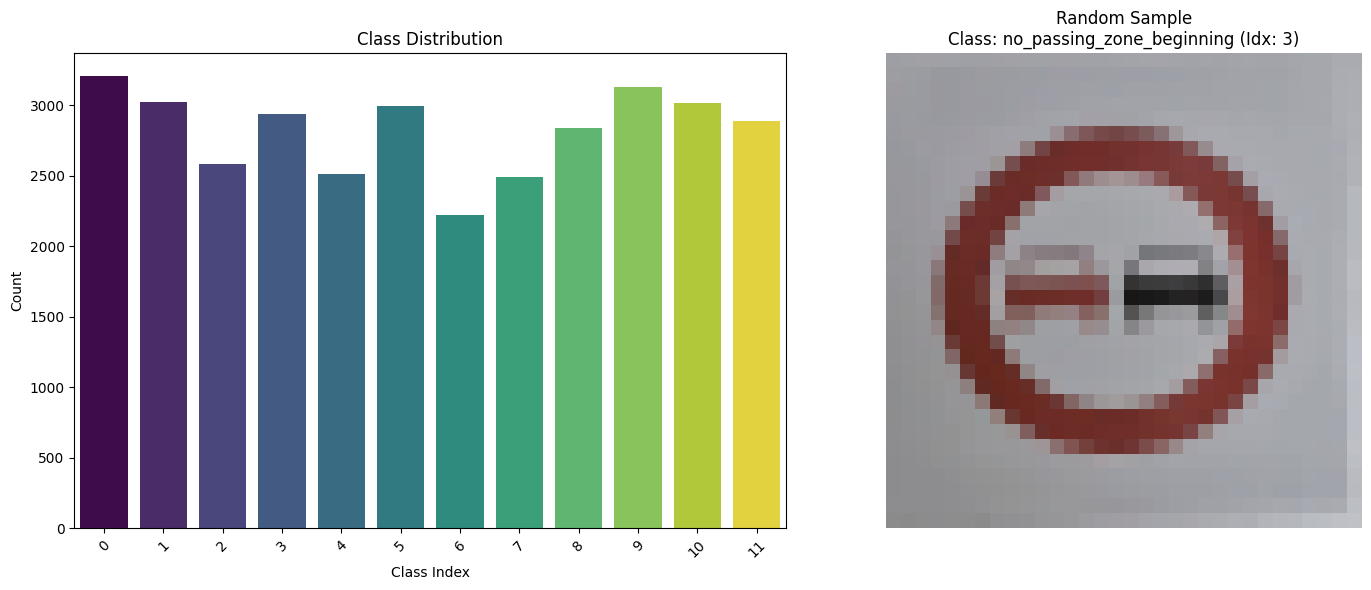

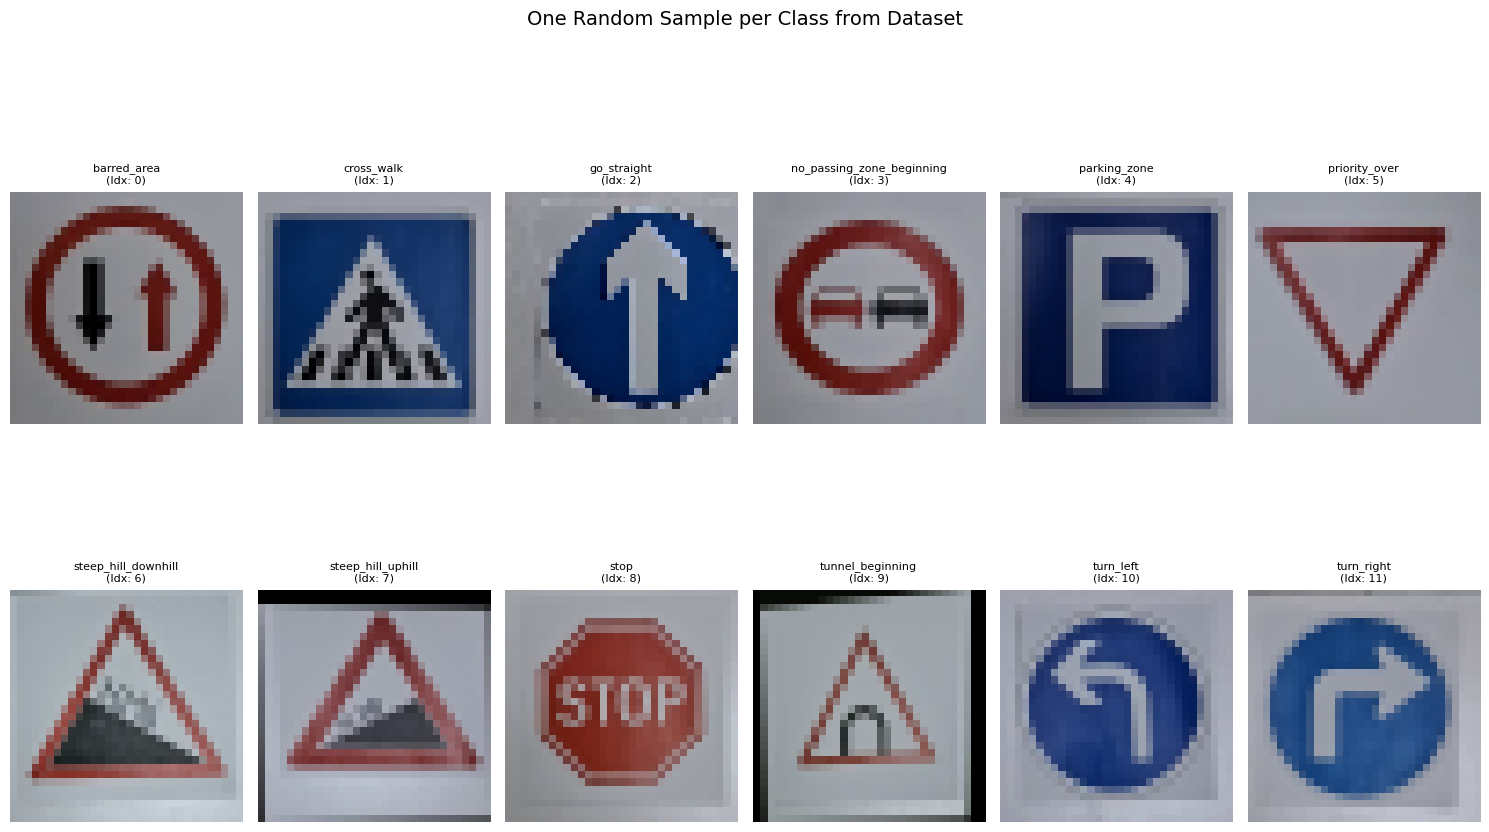

In [139]:
verify_dataset(train_dataset, class_names)


Class Distribution Details:
barred_area (Index 0): 494 samples
cross_walk (Index 1): 465 samples
go_straight (Index 2): 398 samples
no_passing_zone_beginning (Index 3): 452 samples
parking_zone (Index 4): 387 samples
priority_over (Index 5): 461 samples
steep_hill_downhill (Index 6): 342 samples
steep_hill_uphill (Index 7): 384 samples
stop (Index 8): 437 samples
tunnel_beginning (Index 9): 482 samples
turn_left (Index 10): 464 samples
turn_right (Index 11): 444 samples

Class Distribution Summary:
Total samples: 5210
Number of classes: 12
Mean samples per class: 434.2
Std samples per class: 44.2


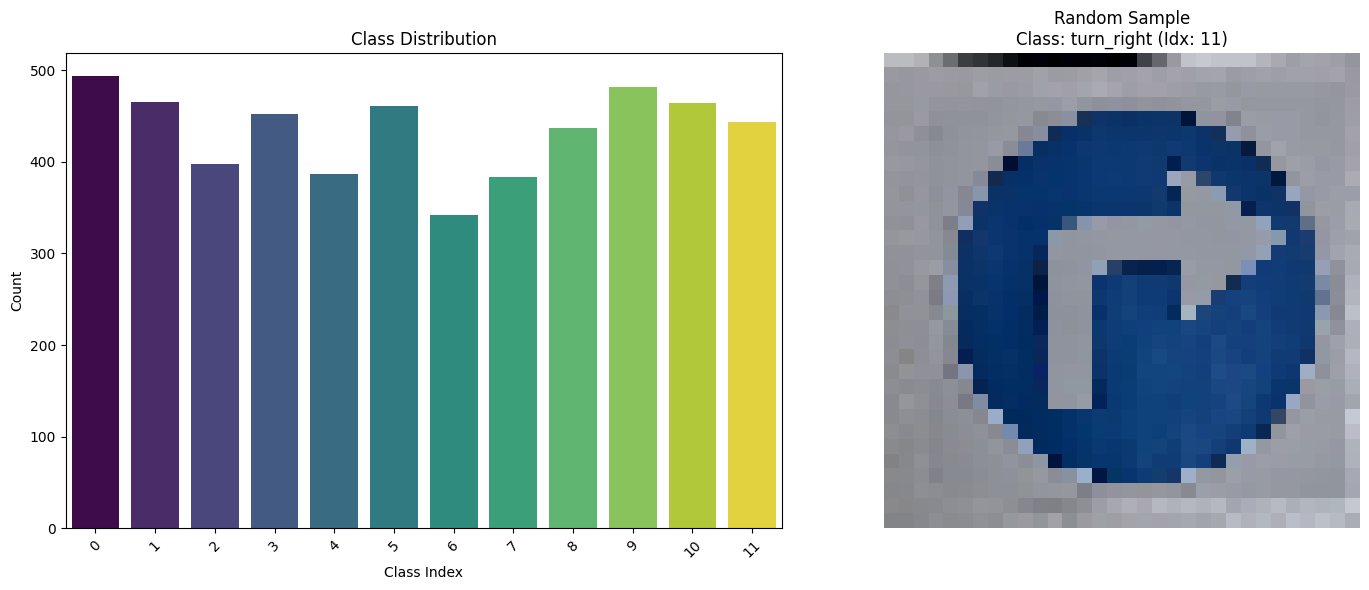

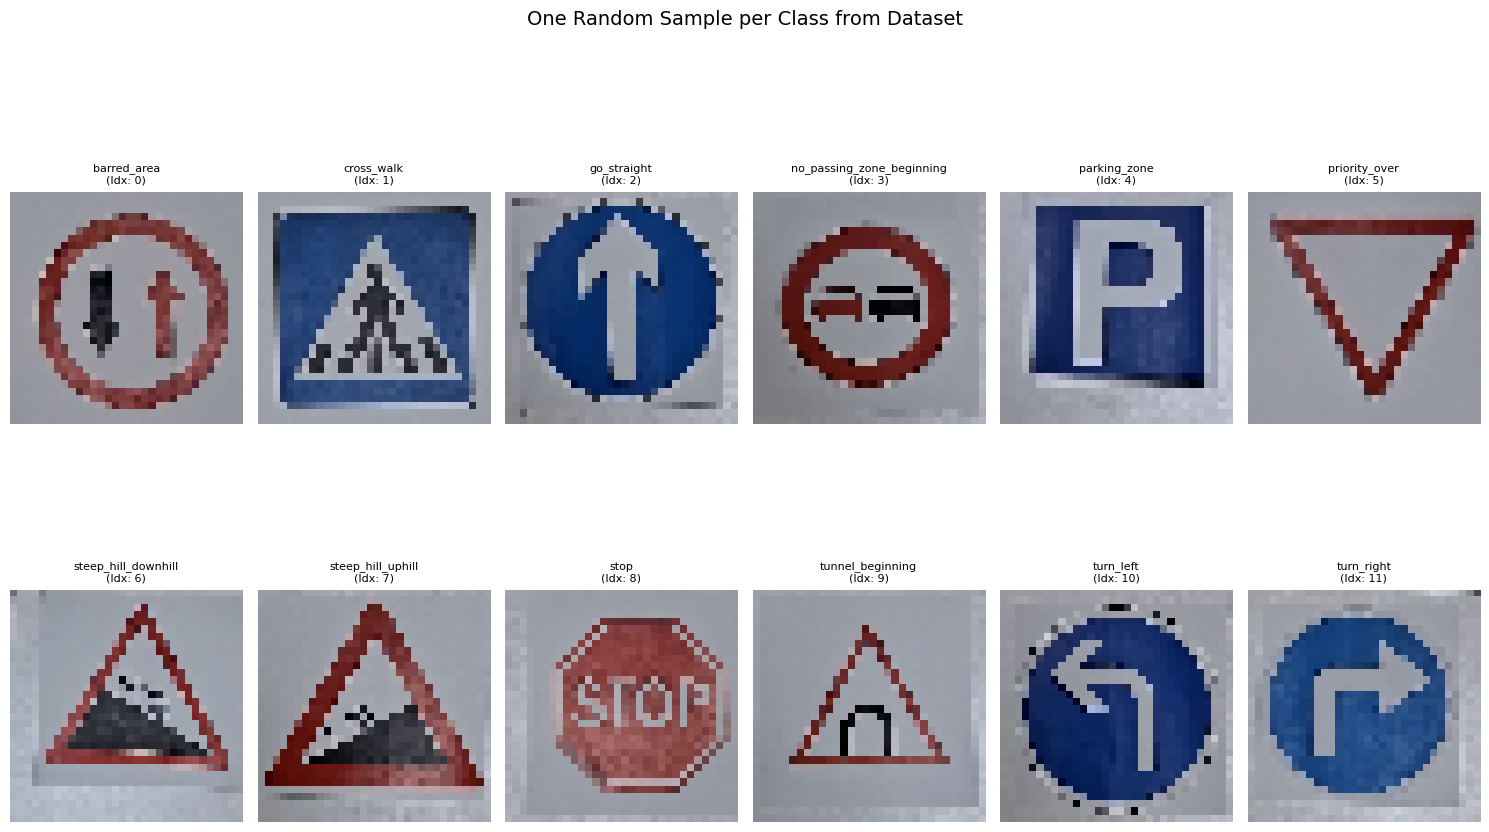

In [140]:
verify_dataset(test_dataset, class_names)

# Training the Model

In [ ]:
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchsummary import summary

### Dataloader

In [ ]:
train_dataset = TrafficSignDB(train_paths_SS, train_labels_SS, transform=augmentation_transform)
valid_dataset = TrafficSignDB(valid_paths, valid_labels, transform=validation_transform)
test_dataset  = TrafficSignDB(test_paths, test_labels, transform=validation_transform)

In [ ]:
batch_size = 128

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
    )
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
    )
test_loader  = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
    )

### CNN Model

In [ ]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=12, num_channels=3):
        super().__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(num_channels, 32, 5, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3)
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),  # Smaller kernel
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*8*8, 256),  # Proper input size
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        return self.classifier(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
model = TrafficSignCNN(num_classes=12).to(device)
summary(model, input_size=(3, 32, 32))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

In [ ]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return correct / total

### Training

In [ ]:
num_epochs = 15
best_acc = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        running_loss += loss.item()
    
    val_acc = evaluate(model, valid_loader, device)
    avg_loss = running_loss / len(train_loader)
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "traffic_sign_cnn_V02.pth")
    print(f"Epoch {epoch+1}: Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}")

print("Final model saved!")
torch.save(model.state_dict(), "traffic_sign_cnn_V02_F.pth")